In [1]:
## aim to predict the escalation of users using RNN and compare with other baseline classfiers

In [34]:
import pandas as pd
import numpy 
import os
import git
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot
import numpy as np
import re
from collections import Counter
# import gensim
# from gensim import corpora
import os
import networkx as nx
import ast

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [36]:
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import SGD
from keras.models import Model, Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Reshape
from keras.layers import Average
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

In [38]:
## Read the labelled files and the poly_user
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [39]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [40]:
# setup env
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
## tokenize the text..
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer as keras_Tokenizer
from sklearn.metrics import classification_report
from keras.layers import Embedding
from nltk.tokenize import TweetTokenizer
tweet_tknzr = TweetTokenizer()
def get_tokens(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tokens = tweet_tknzr.tokenize(sentence)
    tokens = [token for token in tokens if (token not in stopwords and len(token) > 1)]
    tokens = [get_lemma(token) for token in tokens]
    return (tokens)

In [219]:
def clean_text(text):
    text = re.sub(r'(https?://\S+)', "", text) ## remove url
    text = re.sub(r'(\@\w+)', "author",text)   ## remove @ mentions with author
    text = re.sub(r'(@)', "",text)             ## remove @ symbols
    text = re.sub(r'(author)',"",text)         ## remove author
    text = re.sub(r'(#)', "",text)             ## removing the hashtags signal 
    text = re.sub(r'(RT )', "",text)         ## remove the retweet info as they dont convey any information
    text = re.sub(r'(^:)',"",text)
    text.rstrip 
    text.lstrip
    return(text)

In [43]:
# create the word2vec dict from the dictionary
def get_word2vec(file_path):
    file = open(file_path, "r")
    if (file):
        word2vec = dict()
#         split = file.read().splitlines()
        for line in file:
            split_line = line.split(' ')
            key = split_line[0] # the first word is the key
            value = np.array([float(val) for val in split_line[1:]])
            word2vec[key] = value
        return (word2vec)
    else:
        print("invalid fiel path")

In [44]:
## get the embedding matrix weights:
from numpy import zeros
def get_embedding_matrix(keras_tkzr,word2vec):
    vocab_size = len(keras_tkzr.word_index) + 1
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in keras_tkzr.word_index.items():
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return (embedding_matrix,vocab_size)

In [45]:
## pass to the bi-lstm model
def create_model(max_len,vocab_size,embedding_matrix):
    input = Input(shape=(max_len,))
    model = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=max_len)(input)
    model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
    model = TimeDistributed(Dense(100,activation='relu'))(model)
    model = Flatten()(model)
    model = Dense(100,activation='relu')(model)
    output = Dense(3,activation='softmax')(model)
    model = Model(input,output)
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return model

In [46]:
## get the trained model
def train_evaluate_model(model,X_train,Y_train,X_test,Y_test):
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
    print('Accuracy: %f' % (accuracy*100))
    Y_pred = model.predict(X_test)
    y_pred = np.array([np.argmax(pred) for pred in Y_pred])
    # scores = cross_val_score(model, X_test, Y_test, cv=5)
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    precision,recall,fscore,_ = precision_recall_fscore_support(Y_test,y_pred)
    return (model,precision,recall,fscore)

In [47]:
top_dir = os.path.join(get_git_root(os.getcwd()))
input_dir = os.path.join(get_git_root(os.getcwd()),"input")
embeddings_dir  = os.path.join(get_git_root(os.getcwd()),"input","embeddings")
annotatted_dir = os.path.join(input_dir,"annotated_data")
classifier_dir = os.path.join(get_git_root(os.getcwd()),"models","classifier")
model_dir = os.path.join(get_git_root(os.getcwd()),"models")
poly_dir = os.path.join(model_dir,"poly_users")

In [48]:
# so wil filter the users that does have weed tweet before 2016
# it return the mono user in that year
def get_mono(first_data,year):
    first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
    first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])
    juul_users = list(first_data["userID"].loc[first_data["juul_first"].dt.year < year])
    print("juul_initial",len(juul_users))
    weed_users = list(first_data["userID"].loc[(first_data["weed_first"].dt.year < (year))])
    mono_users = list(set(juul_users) - set(weed_users))
    print("mono final",len(mono_users))
    return mono_users

In [49]:
## return the label of the poly users
def get_label_mono(tweets_data,first_data):  ## will change for year
    users = tweets_data.userID.unique()
    print("initial_users",len(users))
    poly_labelled =  list(first_data["userID"].loc[first_data.userID.isin(users) & (first_data.weed_first.isnull())]) ## all not null will become poly
    mono_labelled = (list(set(users) - set(poly_labelled)))   ## users that will change to poly in future year
    print("poly_users that will change",len(poly_labelled))
    print("users reaminin mono",len(mono_labelled))
    tweets_data["label"] = 0   ## initialize
    tweets_data.loc[tweets_data.userID.isin(poly_labelled),"label"] = 1  # all of the poly
    return(tweets_data)

In [50]:
def get_f1(Y_true,Y_pred):
    f_scores = precision_recall_fscore_support(Y_true,Y_pred)[2]
    supports = precision_recall_fscore_support(Y_true,Y_pred)[3]
    f1_num = 0
    for f_s,sup in zip(f_scores,supports):
        f1_num += (f_s * sup)
    f1 = f1_num / np.sum(supports)
    return(f1)

In [51]:
## join al the of the tweets for each user
def get_tweets_user(df):
    tqdm.pandas()
    df = df.groupby(['userID'])['tweetText'].progress_apply(lambda x: ','.join(x)).reset_index()
    return (df)

In [53]:
def get_lstm_model(max_len,dimension,embedding_matrix):
    max_len= max_len
    n_words = vocab_size
    print("creating model")
    input = Input(shape=(max_len,))
    model = Embedding(n_words,Dimension,weights=[embedding_matrix],input_length=max_len)(input)
    model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
    model = Flatten()(model)
    model = Dense(100,activation='relu')(model)
    output = Dense(2,activation='sigmoid')(model)
    model = Model(input,output)
    # sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    print("compiling the model")
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [504]:
## returns the emnbedding matrix for the lstm model
def get_embedding_matrix(vocab_size,dimension,embedding_file,keras_tkzr):
    word2vec = get_word2vec(embedding_file)
    from numpy import zeros
    embedding_matrix = zeros((vocab_size, dimension))
    for word, i in keras_tkzr.word_index.items():
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [54]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
mono_users = pickle.load(open(os.path.join(poly_dir,"mono_users.pkl"),"rb"))

In [96]:
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")

In [56]:
## we taking data from juul and weed and not use the pattern
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
# ## filter the juul data to capture just the regualr users
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## we keep only the regular usrs
first_data = first_data.loc[first_data.userID.isin(regular_users)]

## we look at weed first and juul first tweets
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [57]:
## so will train the classfier on the bucket data

In [58]:
## bucket the users in bucket :
#1 2015 - [2015-2018] 
#2 2015- 2016 - [17 - 18]
#3 2015 - 2017 - [18]

## Sequential prediction using LSTM and baseline classfier for 2018 data

In [97]:
## so we are taking the users that start on Jan 2018 and change in the month of september, 
# and we change the threshold of input data to see how accurately we can predict that

In [352]:
## input data :juul_data 
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## look at the weed first and juul_first tweet
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
first_data = first_data.loc[first_data.userID.isin(regular_users)]  # reg users
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [353]:
## removing the rewteet text column completely
ids_ = juul_data.loc[juul_data['retweetText'].notnull()]["tweetId"]
juul_data.loc[juul_data.tweetId.isin(ids_),"tweetText"] = juul_data.loc[juul_data.tweetId.isin(ids_)]["retweetText"]
juul_data = juul_data.drop(["hashtags","retweetText"],axis=1)
len(juul_data) ## 1353987 (sanity check)

1353987

In [354]:
len(juul_data) ## 1353987
len(juul_data.userID.unique()) ## 673724  reg users

673724

In [355]:
pd.isnull(list(first_data.loc[first_data.userID == 2534]["weed_first"])[0])

True

In [356]:
## get the users who start at jan 2018 
users_2018 = list(first_data["userID"].loc[ 
    (first_data.juul_first.dt.year == 2018)  
    & (first_data.juul_first.dt.month== 1)   ## selecting 2018, Jan data
    & ((first_data.weed_first.dt.month >= 9) | (pd.isnull(first_data.weed_first)))]) # users who will change after september

poly_lbl = list(first_data["userID"].loc[(first_data.juul_first.dt.year == 2018)  
                                         & (first_data.juul_first.dt.month== 1) 
                                           & (first_data.weed_first.dt.month >= 9)]) ## users that will change
print("total users", len(users_2018))
print("users will change",len(poly_lbl))

total users 15966
users will change 6135


In [357]:
data_2018 = juul_data.loc[juul_data.userID.isin(users_2018) & (juul_data.tweetCreatedAt.dt.year == 2018)]
print("total data", len(data_2018))
print("users",len(data_2018.userID.unique()))

## sanity check -- all users start in 2018 year..
data_2018 = juul_data.loc[juul_data.userID.isin(users_2018)]
print("total data", len(data_2018))
print("users",len(data_2018.userID.unique()))

total data 40430
users 15966
total data 40430
users 15966


In [359]:
## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_2018.userID.unique()
users_labelled = pd.DataFrame(users_,columns=["userID"])
users_labelled["label"] = 0  ## initialize
users_labelled.loc[users_labelled.userID.isin(poly_lbl) , "label"] = 1
len(users_labelled.loc[users_labelled.label == 1])  ## sanity check

6135

In [421]:
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")


### functions for sequence LSTM

In [479]:
def get_length(s):
    a = list(s.split())
    return(len(a))

In [627]:
## get window size
def get_window_size(df):
    tweet_count = df.groupby(by="userID")["tweetId"].count()
    tweet_count = tweet_count.reset_index()
    window = int(tweet_count.tweetId.quantile(0.95))
    return window

In [671]:
def get_max_length(df):
    ## max_length
    lengths = df["tweetText"].progress_apply(get_length)
    max_len = int(lengths.quantile(0.95))
    return (max_len)

In [482]:
def get_sequence(df,column,window,max_len):
    users = df.userID.unique()  # select the unique users
    X = []
    for user in tqdm(users):
        temp = list(df[column].loc[df.userID.isin([user])])
        if len(temp) < window:
            pad = np.zeros(((window-len(temp)),max_len))  # pad in case data is less than the window
            data = np.vstack((temp,pad))
        else:
            data = temp[:window]             ## truncate to be equal to window size
        X.append(data)
    return np.array(X)

In [775]:
def plot_coeff(k,model,feature_names):
    coef = (model.coef_.ravel()) 
    top_positive_coefficients = np.argsort(coef)[-k:]
    top_negative_coefficients = np.argsort(coef)[:k]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(17, 8))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * k), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * k), feature_names[top_coefficients], rotation=60, ha='right',fontsize= 20)
    plt.show()
    return coef

In [696]:
def get_lstm_tweet_seq(max_len,window,vocab_size,embedding_matrix):
    max_len= max_len
    n_words = vocab_size
    Dimension = 100
    input = Input(shape=(window,max_len,))
    model = Embedding(n_words,Dimension,weights=[embedding_matrix],input_length=(window,max_len,))(input)
    model = Reshape(target_shape=(window,(max_len*Dimension)))(model)
    # model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.25),merge_mode='concat')(model)
    model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.25),merge_mode='concat')(model)
    model = Flatten()(model)
    output = Dense(2,activation='sigmoid')(model)
    model = Model(input,output)
    # sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    print("compiling the model")
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [693]:
def training_plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [701]:
def run_sequence_model(df,users_labelled,epoch):
    dimension = 100
    
    ## data
    print("length of the data",len(df))
    
    print("users",len(df.userID.unique()))
    
    ## cleaning 
    print("cleanining the data")
    tqdm.pandas()
    df["tweetText"] = df["tweetText"].progress_apply(clean_text)
    
    ## print winodow , max_len for analysis purpose
    max_len = get_max_length(df)
    print("max_length",max_len)
    window= get_window_size(df)
    print("window_size",window)

    ## prepare the tokenizer
    print("preparing the tokenizer")
    keras_tkzr1 = keras_Tokenizer()
    keras_tkzr1.fit_on_texts(df["tweetText"])
    vocab_size = len(keras_tkzr1.word_index) + 1
    print("vocalb",vocab_size)
    
    ## embedding matrix
    print("creating glove embeddign matrix")
    embedding_matrix = get_embedding_matrix(vocab_size,dimension,embedding_file,keras_tkzr1) ## tokenizer contains the vocalb info

    ## encoding the docs
    print("encoding the data")
    encoded_docs = keras_tkzr.texts_to_sequences(df["tweetText"])
    df["encoded_docs"] = list(pad_sequences(encoded_docs, maxlen=max_len, padding='post'))
    
    ## get sequnced data (X)
    print("sequencing data")
    X = get_sequence(df,"encoded_docs",window,max_len)

    ## getting output label 
    print("getting the output label")
    temp = df.groupby(by="userID")["tweetId"].count().reset_index()
    ## join with the users_labelled data to preserve the order
    temp = temp.join(users_labelled.set_index("userID"),on="userID",how="inner")
    y = list(temp["label"])

    ## split the data
    print("train-test split")
    X_train,X_test,Y_train,Y_test  = train_test_split(X, np.array(y),test_size =0.20,random_state= 4,shuffle=True ,
                                                      stratify= np.array(y))

    print(X_train.shape)
    print(X_test.shape)
    print(Y_train.shape)

    
    print("creating lstm model")
    model = get_lstm_tweet_seq(max_len,window,vocab_size,embedding_matrix)
    
    print("training the model")
    history = model.fit(X_train,Y_train,validation_split=0.25, nb_epoch = epoch, verbose = 1)

    ##plotting trainin validation
    training_plot(history)
    
    print("generating classfication report")
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
    print('Accuracy: %f' % (accuracy*100))
    ## lstm model
    temp = model.predict(X_test)
    y_pred = [np.argmax(value) for value in temp] 
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    f1_score = (get_f1(Y_test,y_pred))
    
    print("job finished")
    return (model,f1_score)

In [763]:
def run_baslines(df,users_labelled):
    df["tweetText"] = df["tweetText"].progress_apply(clean_text)
    data = df.groupby(by="userID")["tweetText"].apply(lambda x: "%s" % ' '.join(x)).reset_index()
    data = data.join(users_labelled.set_index("userID"),on="userID",how="inner")
    # ## prepare the tokenizer
    print("preparing the tokenizer")
    tf_idf = TfidfVectorizer(sublinear_tf=True)
    tf_idf.fit(data["tweetText"])
    X = tf_idf.fit_transform(data["tweetText"])
    y = list(data["label"])
    print("train-test split")
    X_train,X_test,Y_train,Y_test  = train_test_split(X, np.array(y),test_size =0.20,random_state= 4,shuffle=True ,
                                                          stratify= np.array(y))
    print("training the models")
    print("svm")
    svm = LinearSVC(C=1,verbose=1)
    svm.fit(X_train,Y_train)
    
    print("rf")
    rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
    rf.fit(X_train,Y_train)
    
    print("predicting scores")
    y_pred = svm.predict(X_test)
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    svm_score = (get_f1(Y_test,y_pred))
    
    y_pred = rf.predict(X_test)
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    rf_score = (get_f1(Y_test,y_pred))

    print("job finished")
    final = {
        'svm': [svm,svm_score],
        'rf' : [rf,rf_score],
        'tf-idf': tf_idf,
    }
    return (final)

In [685]:
## sequence of tweets for user
## output prediction would be for the users so teh lstm layer would need to flatten to a single user..

## poly_turned : if users tweets weed after september (>=9 months) 
## remain_mono :
## seeing the data in different buckets:
#   1  [jan - mar )
#   2  [mar- may )
#   3  [May - july]
#   4  [July - sept]

## use lstm
## use svm
## majority
## xg boost

In [738]:
bucket_data = []

In [739]:
#   1  [jan - mar )
bucket_ = data_2018.loc[(data_2018.tweetCreatedAt.dt.month >= 1) & (data_2018.tweetCreatedAt.dt.month < 3)] ## first
print("length of the data",len(bucket_))
print("total users",len(bucket_.userID.unique()))
bucket_data.append(bucket_)

length of the data 19821
total users 15966


In [740]:
encoded_docs.shape

(15966, 10995)

In [741]:
#   2  [mar- may )
bucket_ = data_2018.loc[(data_2018.tweetCreatedAt.dt.month >= 1) & (data_2018.tweetCreatedAt.dt.month < 5)] ## first
print("length of the data",len(bucket_))
print("total users",len(bucket_1.userID.unique()))
bucket_data.append(bucket_)

length of the data 24163
total users 15966


In [742]:
#   3  [May - july]
bucket_ = data_2018.loc[(data_2018.tweetCreatedAt.dt.month >= 1) & (data_2018.tweetCreatedAt.dt.month < 7)] ## first
print("length of the data",len(bucket_))
print("total users",len(bucket_1.userID.unique()))
bucket_data.append(bucket_)

length of the data 29270
total users 15966


In [743]:
#   4  [July - sept]
bucket_ = data_2018.loc[(data_2018.tweetCreatedAt.dt.month >= 1) & (data_2018.tweetCreatedAt.dt.month < 9)] ## first
print("length of the data",len(bucket_))
print("total users",len(bucket_1.userID.unique()))
bucket_data.append(bucket_)

length of the data 33513
total users 15966


In [744]:
len(bucket_data)

4

length of the data 19821
users 15966
cleanining the data


max_length 59
window_size 2
preparing the tokenizer
vocalb 10995
creating glove embeddign matrix
encoding the data
sequencing data


getting the output label
train-test split
(12772, 2, 59)
(3194, 2, 59)
(12772,)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 2, 59)             0         
_________________________________________________________________
embedding_47 (Embedding)     (None, 2, 59, 100)        1099500   
_________________________________________________________________
reshape_43 (Reshape)         (None, 2, 5900)           0         
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 2, 200)            4800800   
_________________________________________________________________
flatten_6 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 100)               40100     
______________________

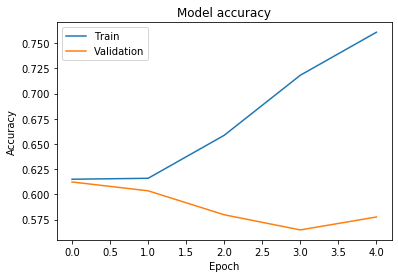

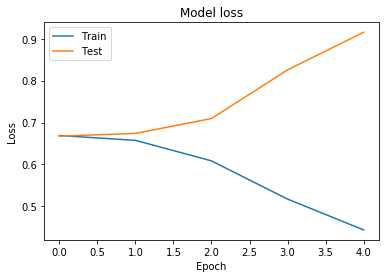

generating classfication report
Accuracy: 57.858485
  Classification Report:
              precision    recall  f1-score   support

          0       0.62      0.84      0.71      1967
          1       0.39      0.16      0.23      1227

avg / total       0.53      0.58      0.53      3194
 

job finished
length of the data 24163
users 15966
cleanining the data


max_length 59
window_size 3
preparing the tokenizer
vocalb 12447
creating glove embeddign matrix
encoding the data
sequencing data


getting the output label
train-test split
(12772, 3, 59)
(3194, 3, 59)
(12772,)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        (None, 3, 59)             0         
_________________________________________________________________
embedding_48 (Embedding)     (None, 3, 59, 100)        1244700   
_________________________________________________________________
reshape_44 (Reshape)         (None, 3, 5900)           0         
_________________________________________________________________
bidirectional_50 (Bidirectio (None, 3, 200)            4800800   
_________________________________________________________________
flatten_7 (Flatten)          (None, 600)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 100)               60100     
______________________

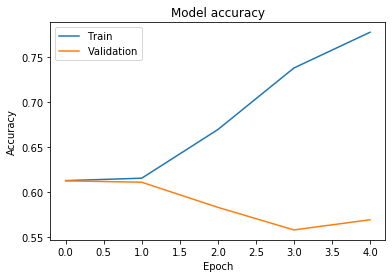

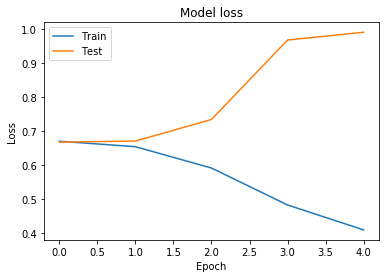

generating classfication report
Accuracy: 57.858485
  Classification Report:
              precision    recall  f1-score   support

          0       0.62      0.80      0.70      1967
          1       0.41      0.22      0.28      1227

avg / total       0.54      0.58      0.54      3194
 

job finished
length of the data 29270
users 15966
cleanining the data


max_length 59
window_size 5
preparing the tokenizer
vocalb 13903
creating glove embeddign matrix
encoding the data
sequencing data


getting the output label
train-test split
(12772, 5, 59)
(3194, 5, 59)
(12772,)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 5, 59)             0         
_________________________________________________________________
embedding_49 (Embedding)     (None, 5, 59, 100)        1390300   
_________________________________________________________________
reshape_45 (Reshape)         (None, 5, 5900)           0         
_________________________________________________________________
bidirectional_51 (Bidirectio (None, 5, 200)            4800800   
_________________________________________________________________
flatten_8 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_80 (Dense)             (None, 100)               100100    
______________________

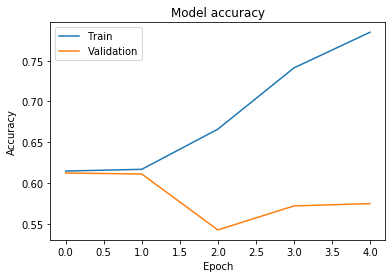

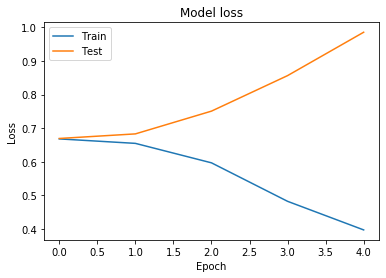

generating classfication report
Accuracy: 58.140263
  Classification Report:
              precision    recall  f1-score   support

          0       0.62      0.84      0.71      1967
          1       0.39      0.16      0.23      1227

avg / total       0.53      0.58      0.53      3194
 

job finished
length of the data 33513
users 15966
cleanining the data


max_length 59
window_size 6
preparing the tokenizer
vocalb 15234
creating glove embeddign matrix
encoding the data
sequencing data


getting the output label
train-test split
(12772, 6, 59)
(3194, 6, 59)
(12772,)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        (None, 6, 59)             0         
_________________________________________________________________
embedding_50 (Embedding)     (None, 6, 59, 100)        1523400   
_________________________________________________________________
reshape_46 (Reshape)         (None, 6, 5900)           0         
_________________________________________________________________
bidirectional_52 (Bidirectio (None, 6, 200)            4800800   
_________________________________________________________________
flatten_9 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_82 (Dense)             (None, 100)               120100    
______________________

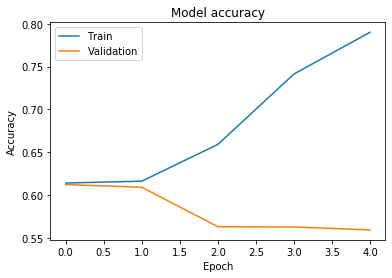

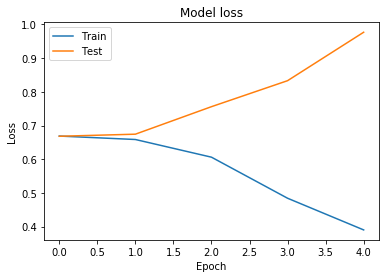

generating classfication report
Accuracy: 56.199123
  Classification Report:
              precision    recall  f1-score   support

          0       0.62      0.77      0.68      1967
          1       0.38      0.23      0.29      1227

avg / total       0.53      0.56      0.53      3194
 

job finished


In [695]:
## run lstm models on all of the sequences
sequence_scores = []
sequence_models = []
for data in bucket_data:
    model,score = run_sequence_model(data,users_labelled,5)
    sequence_scores.append(score)
    sequence_models.append(model)

### majority classfier

In [706]:
y_pred = [1 for x in range(len(Y_test))]
print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
maj_score = (get_f1(Y_test,y_pred))

  Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00      1967
          1       0.38      1.00      0.56      1227

avg / total       0.15      0.38      0.21      3194
 



## using svm approach

In [764]:
svm_scores = []
svm_models= []
rf_models= []
rf_scores = []
tfidf_list = []
for data in bucket_data:
    final = run_baslines(bucket_,users_labelled,)
    svm_model,svm_score = final["svm"]
    rf_mdoel, rf_score = final["rf"]
    tf_idf = final["tf-idf"]
    tfidf_list.append(tf_idf)
    svm_scores.append(score)
    svm_models.append(svm_model)
    rf_scores.append(rf_score)
    rf_models.append(rf_model)

preparing the tokenizer
train-test split
training the models
svm
[LibLinear]rf
predicting scores
  Classification Report:
              precision    recall  f1-score   support

          0       0.67      0.81      0.73      1967
          1       0.54      0.36      0.43      1227

avg / total       0.62      0.63      0.62      3194
 

  Classification Report:
              precision    recall  f1-score   support

          0       0.62      1.00      0.76      1967
          1       1.00      0.00      0.00      1227

avg / total       0.76      0.62      0.47      3194
 

job finished


preparing the tokenizer
train-test split
training the models
svm
[LibLinear]rf
predicting scores
  Classification Report:
              precision    recall  f1-score   support

          0       0.67      0.81      0.73      1967
          1       0.54      0.36      0.43      1227

avg / total       0.62      0.63      0.62      3194
 

  Classification Report:
              precision    recall  f1-score   support

          0       0.62      1.00      0.76      1967
          1       1.00      0.00      0.00      1227

avg / total       0.76      0.62      0.47      3194
 

job finished


preparing the tokenizer
train-test split
training the models
svm
[LibLinear]rf
predicting scores
  Classification Report:
              precision    recall  f1-score   support

          0       0.67      0.81      0.73      1967
          1       0.54      0.36      0.43      1227

avg / total       0.62      0.63      0.62      3194
 

  Classification Report:
              precision    recall  f1-score   support

          0       0.62      1.00      0.76      1967
          1       1.00      0.00      0.00      1227

avg / total       0.76      0.62      0.47      3194
 

job finished


preparing the tokenizer
train-test split
training the models
svm
[LibLinear]rf
predicting scores
  Classification Report:
              precision    recall  f1-score   support

          0       0.67      0.81      0.73      1967
          1       0.54      0.36      0.43      1227

avg / total       0.62      0.63      0.62      3194
 

  Classification Report:
              precision    recall  f1-score   support

          0       0.62      1.00      0.76      1967
          1       1.00      0.00      0.00      1227

avg / total       0.76      0.62      0.47      3194
 

job finished


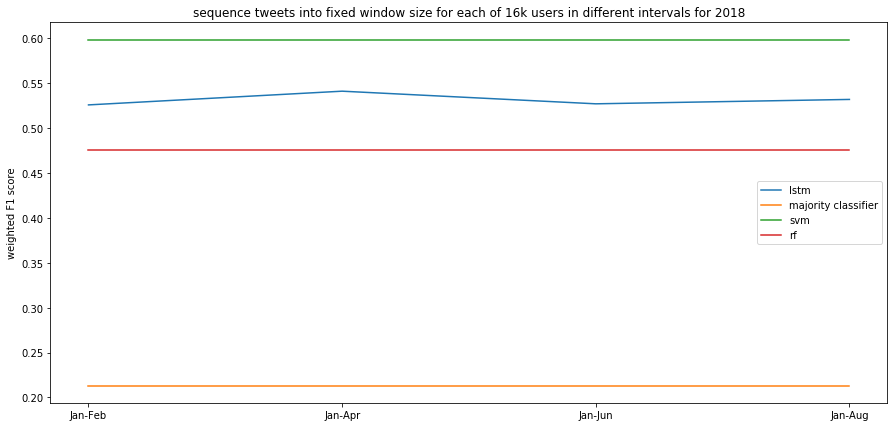

In [757]:
plt.figure(figsize=(15,7))
months = ["Jan-Feb","Jan-Apr","Jan-Jun","Jan-Aug"]
plt.plot(months,sequence_scores,label="lstm")
plt.plot(months,(4*[maj_score]),label="majority classifier")
plt.plot(months,svm_scores,label="svm")
plt.plot(months,rf_scores,label="rf")
plt.title("sequence tweets into fixed window size for each of 16k users in different intervals for 2018")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

Jan-Feb


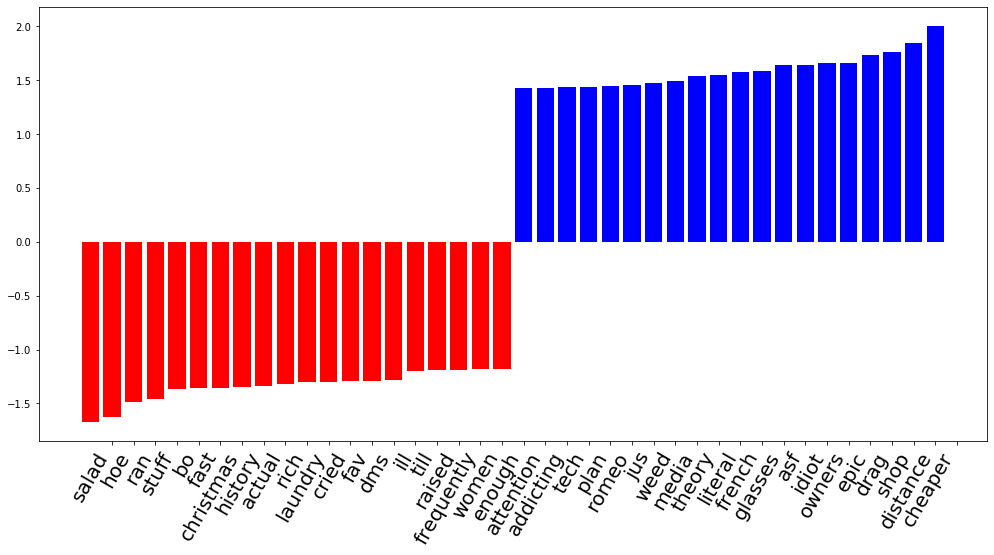

Jan-Apr


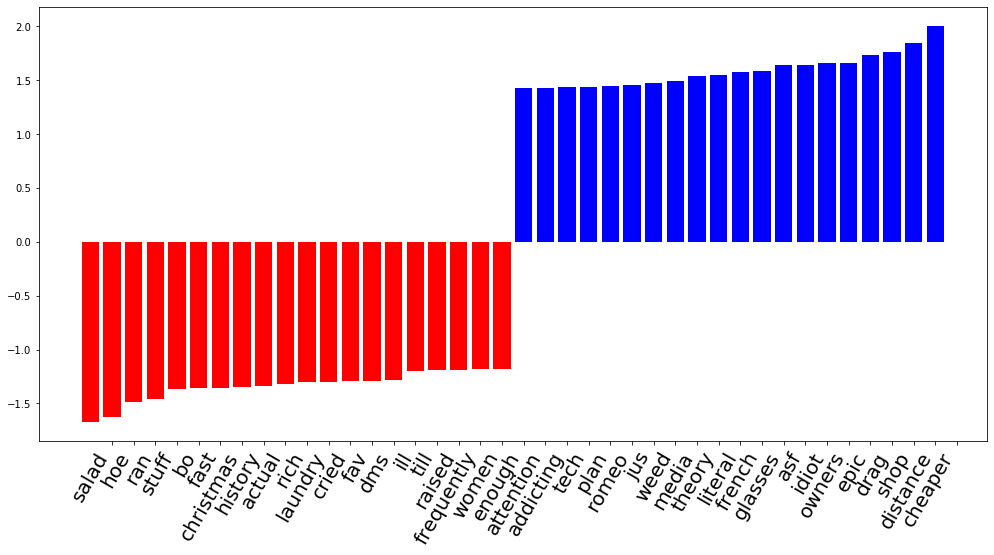

Jan-Jun


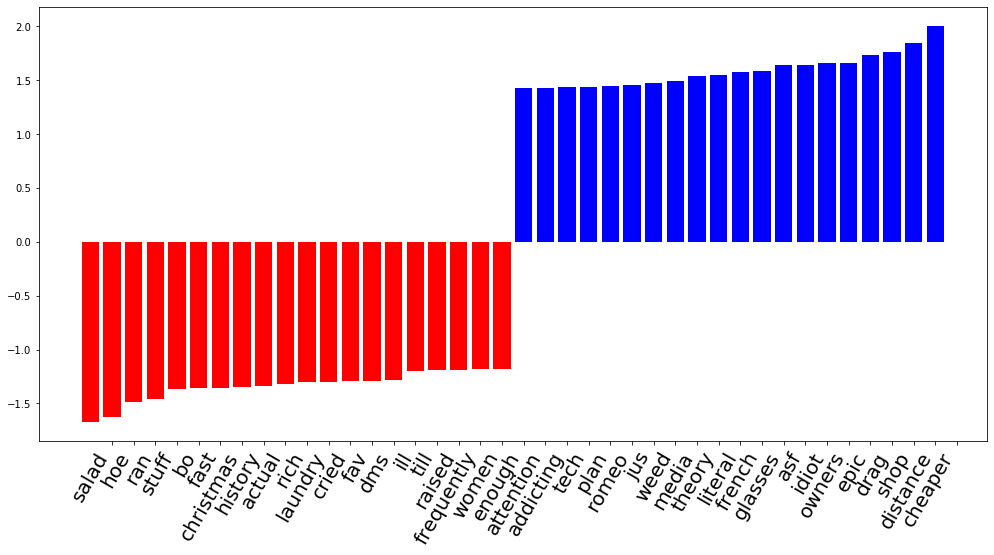

Jan-Aug


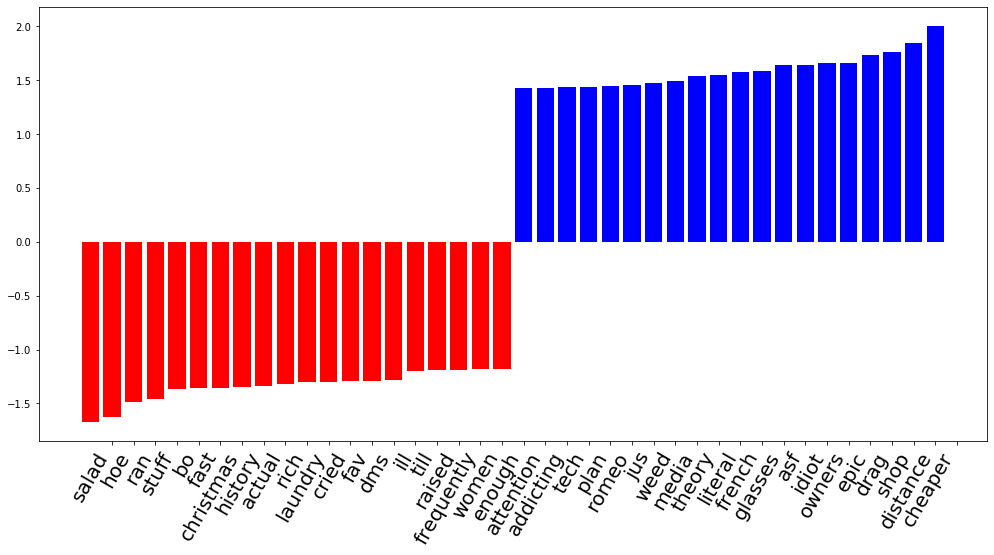

In [776]:
for svm,tf_idf,month in zip(svm_models,tfidf_list,months):
    print(month)
    plot_coeff(20,svm,tf_idf.get_feature_names())

In [777]:
## dump the scores
# with open(os.path.join(input_dir,"sequence_score.pkl"),"wb") as f:
#     pickle.dump(sequence_scores,f)

# with open(os.path.join(input_dir,"sequence_models.pkl"),"wb") as f:
#     pickle.dump(sequence_models,f)
    
# with open(os.path.join(input_dir,"svm_models.pkl"),"wb") as f:
#     pickle.dump(svm_models,f)

# with open(os.path.join(input_dir,"tf_idfs.pkl"),"wb") as f:
#     pickle.dump(tfidf_list,f)

In [526]:
sequence_scores = pickle.load(open(os.path.join(input_dir,"sequence_score.pkl"),"rb"))

array([0.21323756, 0.21323756, 0.21323756, 0.21323756])

In [527]:
sequence_scores

[0.5321313761102834,
 0.5286587720826345,
 0.5345769583362259,
 0.5352044505888427]

### Bucket1

### preparing data

In [26]:
mono_ = get_mono(first_data,2016)

juul_initial 1792
mono final 1140


In [27]:
len(set(mono_users).intersection(set(mono_))) ## this should be labelled as 0
# first_data.loc[first_data.userID.isin(mono_)]

952

In [28]:
 ## select the data for the users in that year
mono_data_2015 = juul_data.loc[(juul_data.userID.isin(mono_)) & (juul_data.tweetCreatedAt.dt.year < 2016)]  
print(len(mono_data_2015))
print(len(mono_data_2015.userID.unique()))
tweets_2015 = get_tweets_user(mono_data_2015)  ## concatenating tweets by user
print("tweets",len(tweets_2015))
print("users",len(tweets_2015.userID.unique()))

2131
1140



tweets 1140
users 1140


In [126]:
## gettting labels
tweets_2015 = get_label_mono(tweets_2015,first_data)
tweets_2015["label"].unique()
## 0 : mono
## 1 : poly
y = list(tweets_2015["label"])
print("mono",len([ele for ele in y if ele == 0]))
print("poly",len([ele for ele in y if ele == 1]))

initial_users 1140
poly_users that will change 952
users reaminin mono 188
mono 188
poly 952


In [127]:
## clean the tweets
tweets_2015["tweetText"] = tweets_2015["tweetText"].apply(clean_text)

In [128]:
## load the tokenizer 
max_len = 26
keras_tkzr = keras_Tokenizer()
keras_tkzr.fit_on_texts(tweets_2015["tweetText"])
vocab_size = len(keras_tkzr.word_index) + 1
print(vocab_size)

## prepare the encoded data
encoded_docs = keras_tkzr.texts_to_sequences(tweets_2015["tweetText"])
X = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
print(X.shape)

4983
(1140, 26)


In [129]:
X_train,X_test,Y_train,Y_test  = train_test_split(X, np.array(y),test_size =0.20,random_state= 4,shuffle=True ,)

In [130]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(912, 26)
(228, 26)
(912,)


## Training

In [131]:
#### embeddings
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")

In [132]:
word2vec = get_word2vec(embedding_file)
from numpy import zeros
embedding_matrix = zeros((vocab_size, 100))
for word, i in keras_tkzr.word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [133]:
model = get_lstm_model(max_len,100,embedding_matrix)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 26)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 26, 100)           498300    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 26, 200)           160800    
_________________________________________________________________
flatten_8 (Flatten)          (None, 5200)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               520100    
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 202       
Total params: 1,179,402
Trainable params: 1,179,402
Non-trainable params: 0
_________________________________________________________________


In [134]:
history = model.fit(X_train,Y_train,validation_split=0.25, nb_epoch = 6, verbose = 1)

Train on 684 samples, validate on 228 samples
Epoch 1/6
684/684 [==============================] - 19s 28ms/step - loss: 0.5046 - acc: 0.8260 - val_loss: 0.4145 - val_acc: 0.8596
Epoch 2/6
684/684 [==============================] - 4s 6ms/step - loss: 0.4268 - acc: 0.8333 - val_loss: 0.4248 - val_acc: 0.8596
Epoch 3/6
684/684 [==============================] - 4s 6ms/step - loss: 0.3852 - acc: 0.8348 - val_loss: 0.4417 - val_acc: 0.8596
Epoch 4/6
684/684 [==============================] - 4s 6ms/step - loss: 0.3764 - acc: 0.8377 - val_loss: 0.4946 - val_acc: 0.8509
Epoch 5/6
684/684 [==============================] - 4s 6ms/step - loss: 0.3710 - acc: 0.8348 - val_loss: 0.4774 - val_acc: 0.8553
Epoch 6/6
684/684 [==============================] - 4s 6ms/step - loss: 0.3116 - acc: 0.8582 - val_loss: 0.5048 - val_acc: 0.8158


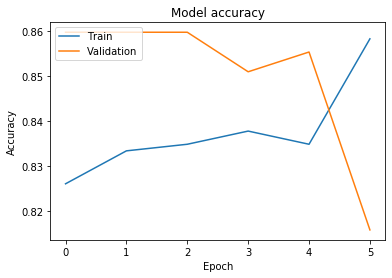

In [135]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [136]:
lstm_scores = []
majority = []
svm_scores = []
rf_scores = []

In [137]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))
## lstm model
from sklearn.metrics import classification_report,confusion_matrix
temp = model.predict(X_test)
y_pred = [np.argmax(value) for value in temp] 
print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
lstm_scores.append(get_f1(Y_test,y_pred))

Accuracy: 78.508772
  Classification Report:
              precision    recall  f1-score   support

          0       0.11      0.02      0.04        42
          1       0.81      0.96      0.88       186

avg / total       0.68      0.79      0.72       228
 



In [138]:
## majority classifier
Y_pred = [1  for ele in range(len(Y_test))]
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
majority.append(get_f1(Y_test,Y_pred))

  Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00        42
          1       0.82      1.00      0.90       186

avg / total       0.67      0.82      0.73       228
 



In [139]:
## svm classfier
svm = LinearSVC(C=1,verbose=1)
svm.fit(X_train,Y_train)
## svm
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()
svm_scores.append(get_f1(Y_test,Y_pred))

[LibLinear]  Classification Report:
              precision    recall  f1-score   support

          0       0.28      0.48      0.35        42
          1       0.86      0.72      0.78       186

avg / total       0.75      0.68      0.70       228
 



In [140]:
## random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()
rf_scores.append(get_f1(Y_test,Y_pred))

  Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00        42
          1       0.82      1.00      0.90       186

avg / total       0.67      0.82      0.73       228
 



### bucket2

In [163]:
year = 2017
mono_ = get_mono(first_data,year)

juul_initial 5619
mono final 2861


In [164]:
len(set(mono_users).intersection(set(mono_))) ## this should be labelled as 0
# first_data.loc[first_data.userID.isin(mono_)]

2329

In [165]:
 ## select the data for the users in that year
mono_data_ = juul_data.loc[(juul_data.userID.isin(mono_)) & (juul_data.tweetCreatedAt.dt.year < year)]  
print("length of data in that span",len(mono_data_))
print("users:",len(mono_data_.userID.unique()))
tweets_ = get_tweets_user(mono_data_)  ## concatenating tweets by user

length of data in that span 6806
users: 2861


In [166]:
print("tweets",len(tweets_))
print("users",len(tweets_.userID.unique()))

tweets 2861
users 2861


In [167]:
tweets_ = get_label_mono(tweets_,first_data)

initial_users 2861
poly_users that will change 2329
users reaminin mono 532


In [168]:
tweets_["label"].unique()
## 0 : mono
## 1 : poly
y = list(tweets_["label"])
print("mono",len([ele for ele in y if ele == 0]))
print("poly",len([ele for ele in y if ele == 1]))

mono 532
poly 2329


In [169]:
## clean the tweets
tweets_["tweetText"] = tweets_["tweetText"].apply(clean_text)

In [170]:
## load the tokenizer 
max_len = 26
keras_tkzr = keras_Tokenizer()
keras_tkzr.fit_on_texts(tweets_["tweetText"])
vocab_size = len(keras_tkzr.word_index) + 1
print(vocab_size)

## prepare the encoded data
encoded_docs = keras_tkzr.texts_to_sequences(tweets_["tweetText"])
X = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
print(X.shape)

10335
(2861, 26)


In [171]:
X_train,X_test,Y_train,Y_test  = train_test_split(X, np.array(y),test_size =0.20,random_state= 4,shuffle=True ,)

In [172]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(2288, 26)
(573, 26)
(2288,)


## Training

In [173]:
embedding_matrix = get_embedding_matrix(100,embedding_file,keras_tkzr)

In [174]:
model = get_lstm_model(max_len,100,embedding_matrix)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 26)                0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 26, 100)           1033500   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 26, 200)           160800    
_________________________________________________________________
flatten_10 (Flatten)         (None, 5200)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               520100    
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 202       
Total params: 1,714,602
Trainable params: 1,714,602
Non-trainable params: 0
_________________________________________________________________


In [175]:
history = model.fit(X_train,Y_train,validation_split=0.25, nb_epoch = 6, verbose = 1)

Train on 1716 samples, validate on 572 samples
Epoch 1/6
1716/1716 [==============================] - 27s 15ms/step - loss: 0.4975 - acc: 0.8100 - val_loss: 0.5176 - val_acc: 0.7815
Epoch 2/6
1716/1716 [==============================] - 11s 6ms/step - loss: 0.4631 - acc: 0.8199 - val_loss: 0.4955 - val_acc: 0.7815
Epoch 3/6
1716/1716 [==============================] - 10s 6ms/step - loss: 0.4327 - acc: 0.8205 - val_loss: 0.4980 - val_acc: 0.7815
Epoch 4/6
1716/1716 [==============================] - 10s 6ms/step - loss: 0.4057 - acc: 0.8176 - val_loss: 0.5235 - val_acc: 0.7815
Epoch 5/6
1716/1716 [==============================] - 10s 6ms/step - loss: 0.3721 - acc: 0.8205 - val_loss: 0.5651 - val_acc: 0.7815
Epoch 6/6
1716/1716 [==============================] - 10s 6ms/step - loss: 0.3254 - acc: 0.8450 - val_loss: 0.5708 - val_acc: 0.7780


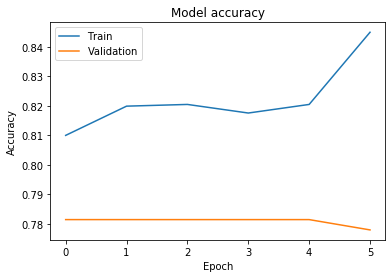

In [176]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [177]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))
## lstm model
temp = model.predict(X_test)
y_pred = [np.argmax(value) for value in temp] 
print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
lstm_scores.append(get_f1(Y_test,y_pred))

Accuracy: 77.486911
  Classification Report:
              precision    recall  f1-score   support

          0       0.21      0.11      0.15        98
          1       0.83      0.91      0.87       475

avg / total       0.73      0.77      0.75       573
 



In [157]:
## majority classifier
Y_pred = [1  for ele in range(len(Y_test))]
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
majority.append(get_f1(Y_test,Y_pred))

  Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00        98
          1       0.83      1.00      0.91       475

avg / total       0.69      0.83      0.75       573
 



In [158]:
## svm classfier
svm = LinearSVC(C=1,verbose=1)
svm.fit(X_train,Y_train)
## svm
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()
svm_scores.append(get_f1(Y_test,Y_pred))

[LibLinear]  Classification Report:
              precision    recall  f1-score   support

          0       0.18      0.40      0.24        98
          1       0.83      0.61      0.71       475

avg / total       0.72      0.58      0.63       573
 



In [159]:
## random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()
rf_scores.append(get_f1(Y_test,Y_pred))

  Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00        98
          1       0.83      1.00      0.91       475

avg / total       0.69      0.83      0.75       573
 



## Bucket 3

In [187]:
# lstm_scores
# majority
# svm_scores
# rf_scores

[0.7330282227307398, 0.7514521135579446]

In [188]:
year = 2018
mono_ = get_mono(first_data,year)

juul_initial 113426
mono final 42784


In [189]:
len(set(mono_users).intersection(set(mono_))) ## this should be labelled as 0
# first_data.loc[first_data.userID.isin(mono_)]

33259

In [190]:
 ## select the data for the users in that year
mono_data_ = juul_data.loc[(juul_data.userID.isin(mono_)) & (juul_data.tweetCreatedAt.dt.year < year)]  
print("length of data in that span",len(mono_data_))
print("users:",len(mono_data_.userID.unique()))
tweets_ = get_tweets_user(mono_data_)  ## concatenating tweets by user

length of data in that span 62655
users: 42784


In [191]:
print("tweets",len(tweets_))
print("users",len(tweets_.userID.unique()))

tweets 42784
users 42784


In [192]:
tweets_ = get_label_mono(tweets_,first_data)

initial_users 42784
poly_users that will change 33259
users reaminin mono 9525


In [193]:
tweets_["label"].unique()
## 0 : mono
## 1 : poly
y = list(tweets_["label"])
print("mono",len([ele for ele in y if ele == 0]))
print("poly",len([ele for ele in y if ele == 1]))

mono 9525
poly 33259


In [194]:
## clean the tweets
tweets_["tweetText"] = tweets_["tweetText"].apply(clean_text)

In [195]:
## load the tokenizer 
max_len = 26
keras_tkzr = keras_Tokenizer()
keras_tkzr.fit_on_texts(tweets_["tweetText"])
vocab_size = len(keras_tkzr.word_index) + 1
print(vocab_size)

## prepare the encoded data
encoded_docs = keras_tkzr.texts_to_sequences(tweets_["tweetText"])
X = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
print(X.shape)

24427
(42784, 26)


In [196]:
X_train,X_test,Y_train,Y_test  = train_test_split(X, np.array(y),test_size =0.20,random_state= 4,shuffle=True , stratify=y)


In [197]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(34227, 26)
(8557, 26)
(34227,)


### Training

In [198]:
embedding_matrix = get_embedding_matrix(100,embedding_file,keras_tkzr)

In [199]:
model = get_lstm_model(max_len,100,embedding_matrix)

creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 26)                0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 26, 100)           2442700   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 26, 200)           160800    
_________________________________________________________________
flatten_11 (Flatten)         (None, 5200)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               520100    
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 202       
Total params: 3,123,802
Trainable params: 3,123,802
Non-trainable params: 0
_______________________________

In [200]:
history = model.fit(X_train,Y_train,validation_split=0.25, nb_epoch = 6, verbose = 1)

Train on 25670 samples, validate on 8557 samples
Epoch 1/6
25670/25670 [==============================] - 183s 7ms/step - loss: 0.5302 - acc: 0.7770 - val_loss: 0.5176 - val_acc: 0.7762
Epoch 2/6
25670/25670 [==============================] - 165s 6ms/step - loss: 0.5087 - acc: 0.7800 - val_loss: 0.5237 - val_acc: 0.7788
Epoch 3/6
25670/25670 [==============================] - 167s 6ms/step - loss: 0.4904 - acc: 0.7820 - val_loss: 0.5247 - val_acc: 0.7782
Epoch 4/6
25670/25670 [==============================] - 166s 6ms/step - loss: 0.4615 - acc: 0.7915 - val_loss: 0.5476 - val_acc: 0.7690
Epoch 5/6
25670/25670 [==============================] - 166s 6ms/step - loss: 0.4313 - acc: 0.8069 - val_loss: 0.6089 - val_acc: 0.7581
Epoch 6/6
25670/25670 [==============================] - 175s 7ms/step - loss: 0.4016 - acc: 0.8209 - val_loss: 0.6345 - val_acc: 0.7579


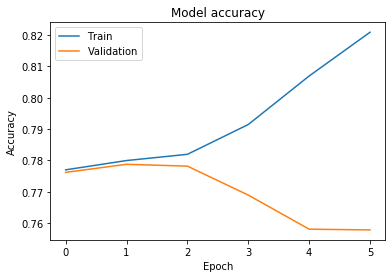

In [201]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [202]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))
## lstm model
temp = model.predict(X_test)
y_pred = [np.argmax(value) for value in temp] 
print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
lstm_scores.append(get_f1(Y_test,y_pred))

Accuracy: 76.592264
  Classification Report:
              precision    recall  f1-score   support

          0       0.40      0.17      0.24      1851
          1       0.80      0.93      0.86      6706

avg / total       0.72      0.77      0.73      8557
 



In [203]:
## majority classifier
Y_pred = [1  for ele in range(len(Y_test))]
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
majority.append(get_f1(Y_test,Y_pred))

  Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00      1851
          1       0.78      1.00      0.88      6706

avg / total       0.61      0.78      0.69      8557
 



In [204]:
## svm classfier
svm = LinearSVC(C=1,verbose=1)
svm.fit(X_train,Y_train)
## svm
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()
svm_scores.append(get_f1(Y_test,Y_pred))

[LibLinear]  Classification Report:
              precision    recall  f1-score   support

          0       0.22      0.77      0.35      1851
          1       0.80      0.27      0.40      6706

avg / total       0.68      0.37      0.39      8557
 



In [205]:
## random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()
rf_scores.append(get_f1(Y_test,Y_pred))

  Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00      1851
          1       0.78      1.00      0.88      6706

avg / total       0.61      0.78      0.69      8557
 



### plotting the classfier acuuracy 

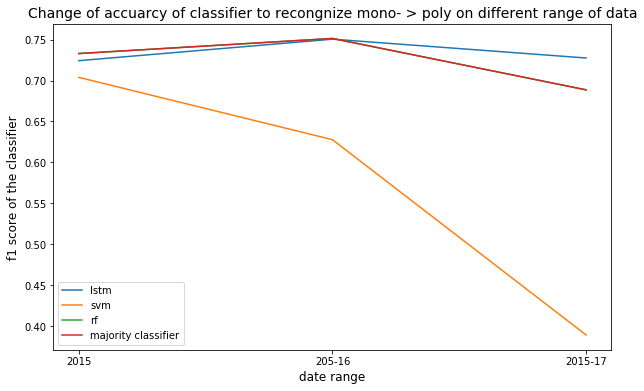

In [214]:
fig, ax = plt.subplots(figsize = (10,6))
x_label = ["2015","205-16","2015-17"]
ax.plot(x_label,lstm_scores,label="lstm")
ax.plot(x_label,svm_scores,label="svm")
ax.plot(x_label,rf_scores,label="rf")
ax.plot(x_label,majority,label="majority classifier")
plt.title("Change of accuarcy of classifier to recongnize mono- > poly on different range of data",fontsize=14)
plt.xlabel("date range",fontsize=12)
plt.ylabel("f1 score of the classifier",fontsize=12)
plt.legend()
plt.show()

## using a sequence approach

In [216]:
## will take a sequence of tweets instead of tweet similar to sequence of spans so that the classifier 
# learns the sequence and then make the prediction 

In [1]:
## will be looking at the data of 2017-18 to look at sequence of spans..

In [27]:
# year = 2018
juul_data_2018 = juul_data.loc[(juul_data["tweetCreatedAt"].dt.year < 2018) & (juul_data["tweetCreatedAt"].dt.year >= 2017)]

In [28]:
len(juul_data_2018)  # 163154
len(juul_data_2018.userID.unique()) ## 109350

163154

In [33]:
## filtering the promoters, and others
weed_users = list(first_data["userID"].loc[(first_data["weed_first"].dt.year < (2018))])
mono_users = list(set(juul_users) - set(weed_users))    
mono_data_2018 = juul_data_2018.loc[juul_data.userID.isin(mono_users)]

NameError: name 'juul_users' is not defined

In [243]:
 ## select the data for the users in that year
mono_data_ = juul_data.loc[(juul_data.userID.isin(mono_)) & (juul_data.tweetCreatedAt.dt.year < year)]  
print(len(mono_data_))
print(len(mono_data_.userID.unique()))

62655
42784


In [126]:
## gettting labels
tweets_2015 = get_label_mono(tweets_2015,first_data)
tweets_2015["label"].unique()
## 0 : mono
## 1 : poly
y = list(tweets_2015["label"])
print("mono",len([ele for ele in y if ele == 0]))
print("poly",len([ele for ele in y if ele == 1]))

initial_users 1140
poly_users that will change 952
users reaminin mono 188
mono 188
poly 952


In [127]:
## clean the tweets
tweets_2015["tweetText"] = tweets_2015["tweetText"].apply(clean_text)

In [128]:
## load the tokenizer 
max_len = 26
keras_tkzr = keras_Tokenizer()
keras_tkzr.fit_on_texts(tweets_2015["tweetText"])
vocab_size = len(keras_tkzr.word_index) + 1
print(vocab_size)

## prepare the encoded data
encoded_docs = keras_tkzr.texts_to_sequences(tweets_2015["tweetText"])
X = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
print(X.shape)

4983
(1140, 26)


In [129]:
X_train,X_test,Y_train,Y_test  = train_test_split(X, np.array(y),test_size =0.20,random_state= 4,shuffle=True ,)

In [130]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(912, 26)
(228, 26)
(912,)


## Training

In [131]:
#### embeddings
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")

In [132]:
word2vec = get_word2vec(embedding_file)
from numpy import zeros
embedding_matrix = zeros((vocab_size, 100))
for word, i in keras_tkzr.word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [133]:
model = get_lstm_model(max_len,100,embedding_matrix)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 26)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 26, 100)           498300    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 26, 200)           160800    
_________________________________________________________________
flatten_8 (Flatten)          (None, 5200)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               520100    
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 202       
Total params: 1,179,402
Trainable params: 1,179,402
Non-trainable params: 0
_________________________________________________________________


In [134]:
history = model.fit(X_train,Y_train,validation_split=0.25, nb_epoch = 6, verbose = 1)

Train on 684 samples, validate on 228 samples
Epoch 1/6
684/684 [==============================] - 19s 28ms/step - loss: 0.5046 - acc: 0.8260 - val_loss: 0.4145 - val_acc: 0.8596
Epoch 2/6
684/684 [==============================] - 4s 6ms/step - loss: 0.4268 - acc: 0.8333 - val_loss: 0.4248 - val_acc: 0.8596
Epoch 3/6
684/684 [==============================] - 4s 6ms/step - loss: 0.3852 - acc: 0.8348 - val_loss: 0.4417 - val_acc: 0.8596
Epoch 4/6
684/684 [==============================] - 4s 6ms/step - loss: 0.3764 - acc: 0.8377 - val_loss: 0.4946 - val_acc: 0.8509
Epoch 5/6
684/684 [==============================] - 4s 6ms/step - loss: 0.3710 - acc: 0.8348 - val_loss: 0.4774 - val_acc: 0.8553
Epoch 6/6
684/684 [==============================] - 4s 6ms/step - loss: 0.3116 - acc: 0.8582 - val_loss: 0.5048 - val_acc: 0.8158


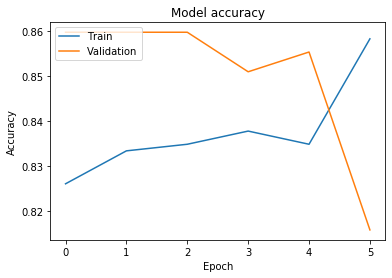

In [135]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [136]:
lstm_scores = []
majority = []
svm_scores = []
rf_scores = []

In [137]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))
## lstm model
from sklearn.metrics import classification_report,confusion_matrix
temp = model.predict(X_test)
y_pred = [np.argmax(value) for value in temp] 
print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
lstm_scores.append(get_f1(Y_test,y_pred))

Accuracy: 78.508772
  Classification Report:
              precision    recall  f1-score   support

          0       0.11      0.02      0.04        42
          1       0.81      0.96      0.88       186

avg / total       0.68      0.79      0.72       228
 

